In [1]:
import os
import gzip
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal
import pandas as pd
import pickle
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import detrend, find_peaks
import os
import gzip
import keras
plt.rcParams['figure.figsize'] = (28,14)## 그래프 크기 조정
from scipy import interpolate
def read_nk(filepath, wavetype, filetype='gz'):## 아주대 의료정보학과 에서 제공하는 데이터의 압축을 풀기 위한 함수 code
    '''
    Nlhoncohden 파일을 읽기 위한 함수
    filepath : waveform filepath
    wavetype : ECGII, ART1(A-line Blood pressure),RESPIMP(Respiratory Impedance),SPO2IRAC(PPG),CVP(Central Venous pressure)
    filetype : gz or csv  (초창기 csv로 저장된 파일을 읽기위함)
    
    Return
    biosignal array(numpy array)
    '''
    if filetype == 'gz':
        with gzip.open(filepath, 'rt') as f:
            content = f.read()
            if wavetype == 'ECGII':
                tmp = np.int32((np.array(content.split(','))[:-1]).reshape(-1))
                tmp = tmp[::2]  #sampling rate 조절하는 부분
                return tmp

            elif wavetype == 'ART1' or wavetype == 'RESPIMP' or wavetype == 'SPO2IRAC' or wavetype == 'CVP':
                tmp = np.int32((np.array(content.split(','))[:-1]).reshape(-1))
                return tmp
    elif filetype == 'csv':
        tmp = pd.read_csv(filepath, header=None).iloc[:, :-1]
        if wavetype == 'ECGII':
            tmp = np.array(tmp).reshape(-1)
            tmp = tmp[::2] #sampling rate 조절하는 부분
            return tmp
        tmp = np.array(tmp).reshape(-1)
        return tmp
def read_ph(filepath, wavetype, filetype=None):
    tmp = zipfile.ZipFile(filepath)
    if wavetype == 'ECGII':
        tmp = pd.read_csv(tmp.open(tmp.namelist()[0]), header=None)[list(range(5000))]
        tmp = np.array(tmp).reshape(-1)
        tmp = tmp[::4]
        return tmp  ## 여기 스케일 조정해야돼 스케일 이슈
    elif wavetype == 'ART1' or wavetype == 'SPO2IRAC':
        tmp = pd.read_csv(tmp.open(tmp.namelist()[0]), header=None)[list(range(1250))]
        tmp = np.array(tmp).reshape(-1)
        return tmp
    elif wavetype == 'RESPIMP':
        tmp = pd.read_csv(tmp.open(tmp.namelist()[0]), header=None)[list(range(625))]
        tmp = np.array(tmp).reshape(-1)
        tmp = np.interp(np.arange(0, len(tmp), 0.5), np.arange(0, len(tmp)), tmp)
        return tmp
    return None

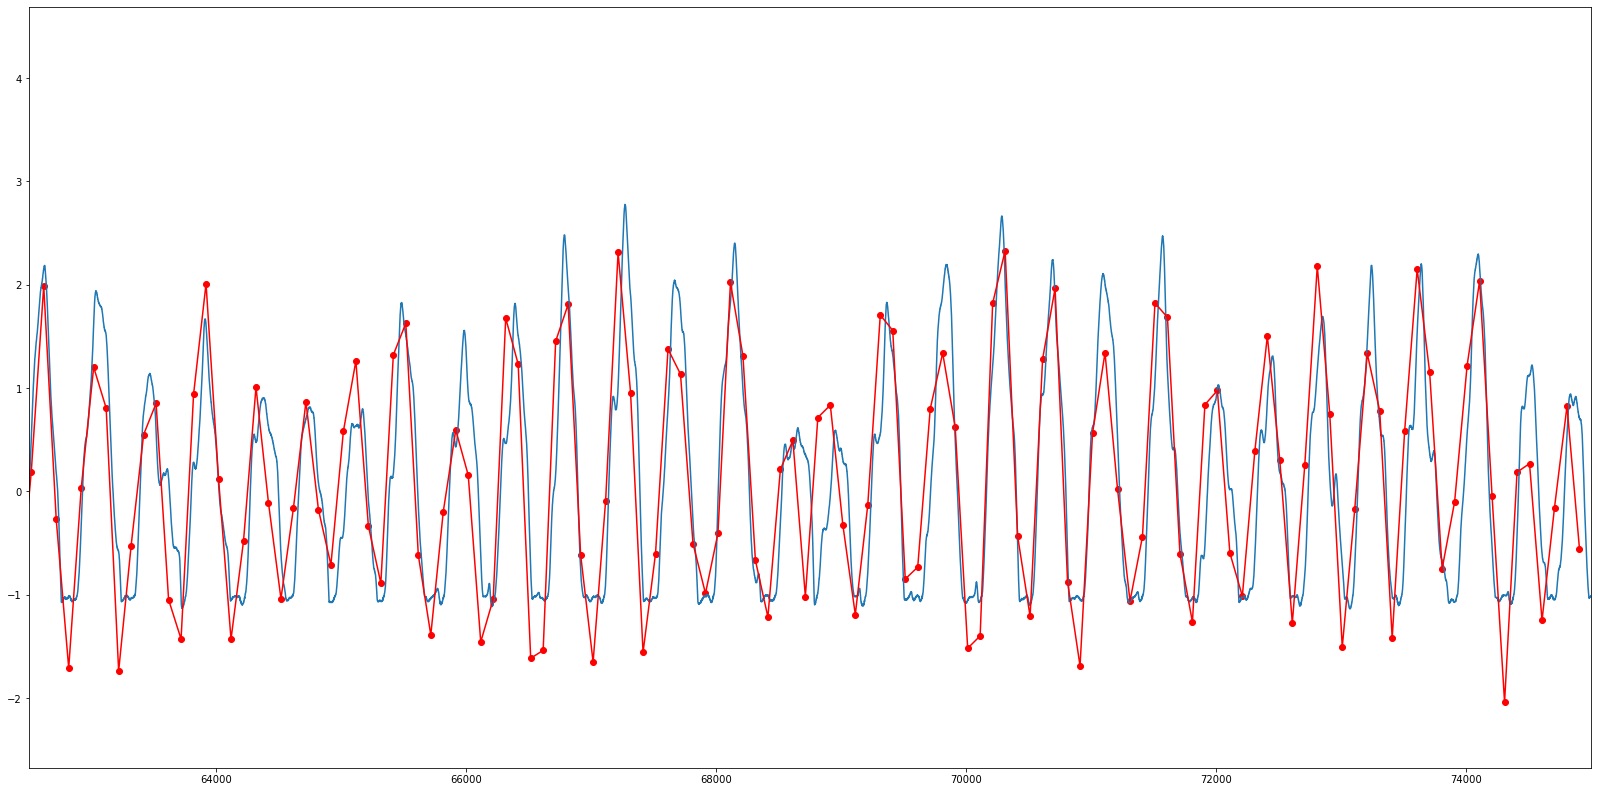

In [648]:
## 첫번째 수정 진행 방향
signal_list=os.listdir('/home/jovyan/work/biosignal/GZIP/0a2ce80208e2cf726f1b/20210406')## 병원 환자 번호와 날짜를 이용한 신호 리스트 확인
DIR_='/home/jovyan/work/biosignal/GZIP/0a2ce80208e2cf726f1b/20210406'
ecg_list = []
res_list = []
for si in range(len(signal_list)):    
    if signal_list[si].split('_')[-1] == 'ECGII.gz':
        ecg_list.append(signal_list[si])
for re in range(len(signal_list)):    
    if signal_list[re].split('_')[-1] == 'RESPIMP.gz':
        res_list.append(signal_list[re])
ECG_ = read_nk(DIR_+'/'+ecg_list[1],'ECGII')
RES_ = read_nk(DIR_+'/'+res_list[1],'RESPIMP')
rr, _ = find_peaks(ECG_, distance=80, height=np.mean(ECG_))##python scipy를 이용해 신호의 peak를 찾는 함수
m_rr, m_ = find_peaks(-ECG_, distance=80, height=np.mean(ECG_))## 기존의 값의 음수를 붙인후 peak를 찾는다
peak_=_['peak_heights']
m_peak_=-m_['peak_heights']
all_rr = []
for i in range(len(rr)):
    all_rr.append(rr[i])

all_rr=np.array(all_rr)
all_peak = []
for i in range(len(rr)):
    all_peak.append(peak_[i]-m_peak_[i])## peak값과 reverse peak 값의 차를 구한다
    #all_peak.append(m_peak_[i])

f1 = interpolate.interp1d(all_rr,all_peak,kind='cubic')## ecg 에서 peak detecetion 
x_new = np.linspace(all_rr[0],all_rr[-1],num=750,endpoint=True)
f1_x=f1(x_new)
f1_x_ = (f1(x_new) - f1(x_new).mean()) / f1(x_new).std()
ECG_n = (ECG_ - ECG_.mean()) / ECG_.std()

RES_n = (RES_ - RES_.mean()) / RES_.std()
#all_peak=np.array(all_peak)
#plt.plot(ECG_n)
plt.plot(RES_n)
plt.plot(x_new, f1_x_,color='red')
plt.scatter(x_new, f1_x_,color='red')
plt.xlim(125*500,125*600)
plt.show()

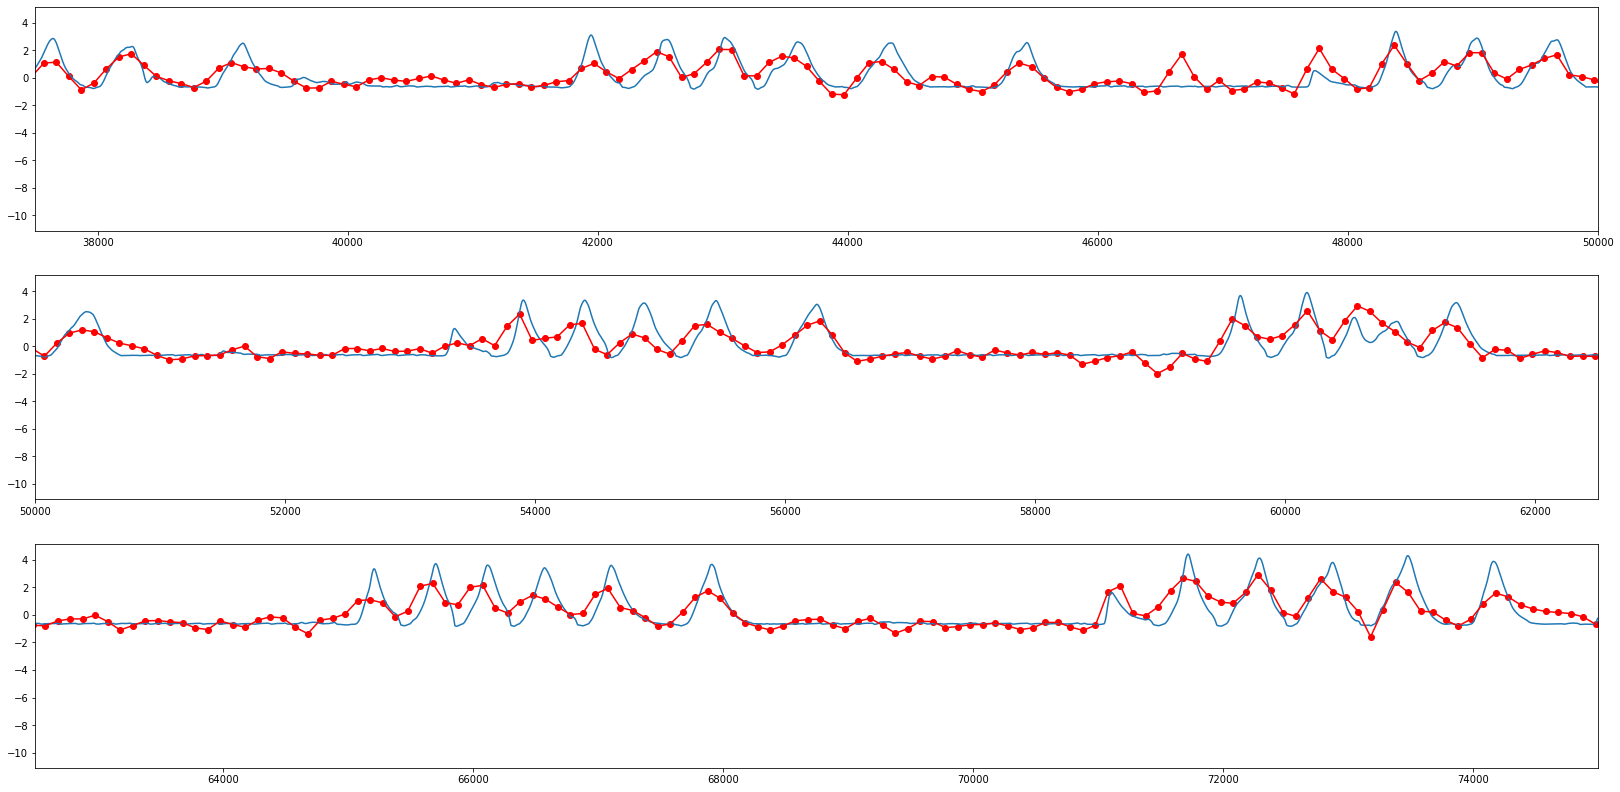

In [712]:
## 두번째 수정 진행 방향
osa_pt_number='0a405f6a12933ff7967d'
csa_pt_number = '0a405f6a12933ff7967d'
csa_day = '20201209'
csa_time_be = '070000'
csa_time_af = '071000'
osa_day = '20201208'
oas_time_be = '150000'
oas_time_af = '151000'
signal_list=os.listdir('/home/jovyan/work/biosignal/GZIP/'+pt_number+'/'+osa_day)
DIR_='/home/jovyan/work/biosignal/GZIP/'+pt_number+'/'+osa_day
ECG_ = read_nk(DIR_+'/'+osa_day+oas_time_be+'_'+osa_day+oas_time_af+'_ECGII.gz','ECGII')
RES_ = read_nk(DIR_+'/'+osa_day+oas_time_be+'_'+osa_day+oas_time_af+'_RESPIMP.gz','RESPIMP')
rr, _ = find_peaks(ECG_, distance=80, height=2*np.mean(ECG_))
peak_=_['peak_heights']
m_rr = []
index_list = []
for i in range(len(rr)):
    try:
        m_rr.append(min(ECG_[rr[i]:rr[i+1]]))
        index_list.append(int(rr[i]+rr[i+1])/2)
    except:
        m_rr.append(min(ECG_[rr[i]:]))
        index_list.append(int(rr[i]+len(ECG_))/2)
di_list = []
for i in range(len(m_rr)):
    di_list.append(peak_[i] - m_rr[i])  
di_array = np.array(di_list)
di_array_ = (di_array - di_array.mean()) / di_array.std()



f1 = interpolate.interp1d(index_list,di_array_,kind='cubic')
x_new = np.linspace(index_list[0],index_list[-1],num=750,endpoint=True)
f1_x=f1(x_new)
f1_x_ = (f1(x_new) - f1(x_new).mean()) / f1(x_new).std()
ECG_n = (ECG_ - ECG_.mean()) / ECG_.std()
RES_n = (RES_ - RES_.mean()) / RES_.std()
peak_n = (peak_ - peak_.mean()) / peak_.std()

fig = plt.figure()## 그래프 객체 생성

ax1 = fig.add_subplot(3,1,1)    
ax1.plot(RES_n)
ax1.plot(x_new, f1_x_, color='red')
ax1.scatter(x_new, f1_x_, color='red')
ax1.set_xlim(125*300,125*400)

ax2 = fig.add_subplot(3,1,2)     
ax2.plot(RES_n)
ax2.plot(x_new, f1_x_, color='red')
ax2.scatter(x_new, f1_x_, color='red')
ax2.set_xlim(125*400,125*500)

ax3 = fig.add_subplot(3,1,3)     
ax3.plot(RES_n)
ax3.plot(x_new, f1_x_, color='red')
ax3.scatter(x_new, f1_x_, color='red')
ax3.set_xlim(125*500,125*600)
plt.show()

In [673]:
#m_rr

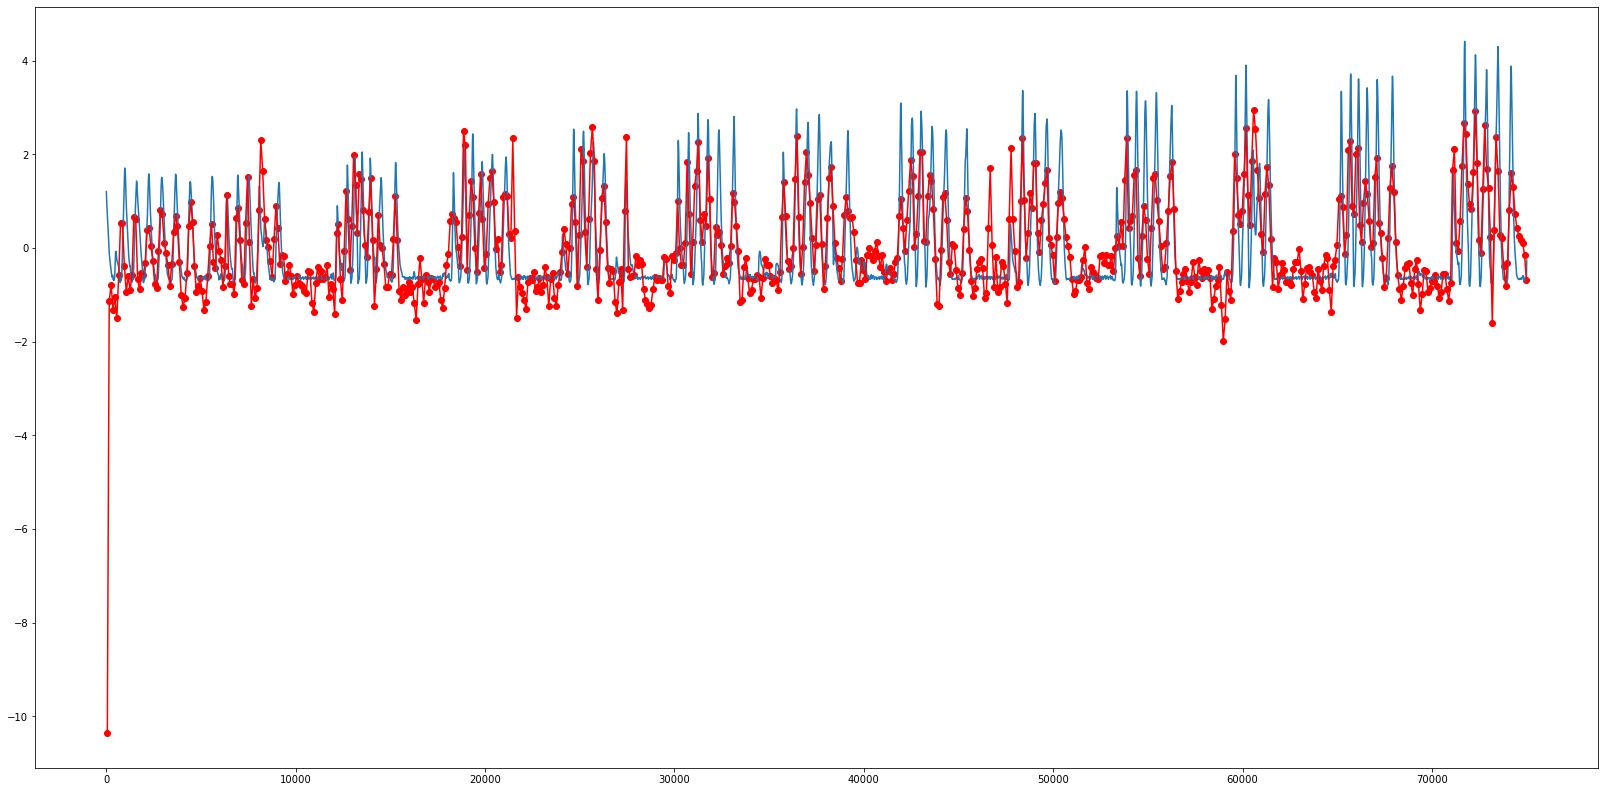

In [711]:
##세번째 수정 진행 방향
osa_pt_number='0a405f6a12933ff7967d'
csa_pt_number = '0a405f6a12933ff7967d'
csa_day = '20201209'
csa_time_be = '070000'
csa_time_af = '071000'
osa_day = '20201208'
oas_time_be = '150000'
oas_time_af = '151000'
signal_list=os.listdir('/home/jovyan/work/biosignal/GZIP/'+pt_number+'/'+osa_day)
DIR_='/home/jovyan/work/biosignal/GZIP/'+pt_number+'/'+osa_day
ECG_ = read_nk(DIR_+'/'+osa_day+oas_time_be+'_'+osa_day+oas_time_af+'_ECGII.gz','ECGII')
RES_ = read_nk(DIR_+'/'+osa_day+oas_time_be+'_'+osa_day+oas_time_af+'_RESPIMP.gz','RESPIMP')
rr, _ = find_peaks(ECG_, distance=80, height=2*np.mean(ECG_))
#_rr, m_ = find_peaks(-ECG_, distance=80, height=2*np.mean(ECG_))
peak_=_['peak_heights']
m_rr = []
index_list = []
for i in range(len(rr)):
    try:
        m_rr.append(min(ECG_[rr[i]:rr[i+1]]))
        index_list.append(int(rr[i]+rr[i+1])/2)
    except:
        m_rr.append(min(ECG_[rr[i]:]))
        index_list.append(int(rr[i]+len(ECG_))/2)
di_list = []
for i in range(len(m_rr)):
    di_list.append(peak_[i] - m_rr[i])  
di_array = np.array(di_list)
di_array_ = (di_array - di_array.mean()) / di_array.std()



f1 = interpolate.interp1d(index_list,di_array_,kind='cubic')
x_new = np.linspace(index_list[0],index_list[-1],num=750,endpoint=True)
f1_x=f1(x_new)
f1_x_ = (f1(x_new) - f1(x_new).mean()) / f1(x_new).std()
#ECG_n = (ECG_ - ECG_.mean()) / ECG_.std()
#RES_n = (RES_ - RES_.mean()) / RES_.std()
#peak_n = (peak_ - peak_.mean()) / peak_.std()
plt.plot(RES_n)
#plt.plot(ECG_n)
plt.plot(x_new, f1_x_, color='red')
plt.scatter(x_new, f1_x_, color='red')
#plt.ylim(min(RES_n),max(RES_n))
#plt.xlim(125*0,125*100)


In [664]:
len(m_rr),len(rr)

(571, 571)

In [667]:
m_rr = []
index_list = []
for i in range(len(rr)):
    try:
        m_rr.append(min(ECG_[rr[i]:rr[i+1]]))
        index_list.append(int(rr[i]+rr[i+1])/2)
    except:
        m_rr.append(min(ECG_[rr[i]:]))
        index_list.append(int(rr[i]+len(ECG_))/2)
di_list = []
for i in range(len(m_rr)):
    di_list.append(rr[i] - m_rr[i])  
di_array = np.array(di_list)
di_array_ = (di_array - di_array.mean()) / di_array.std()


571 651


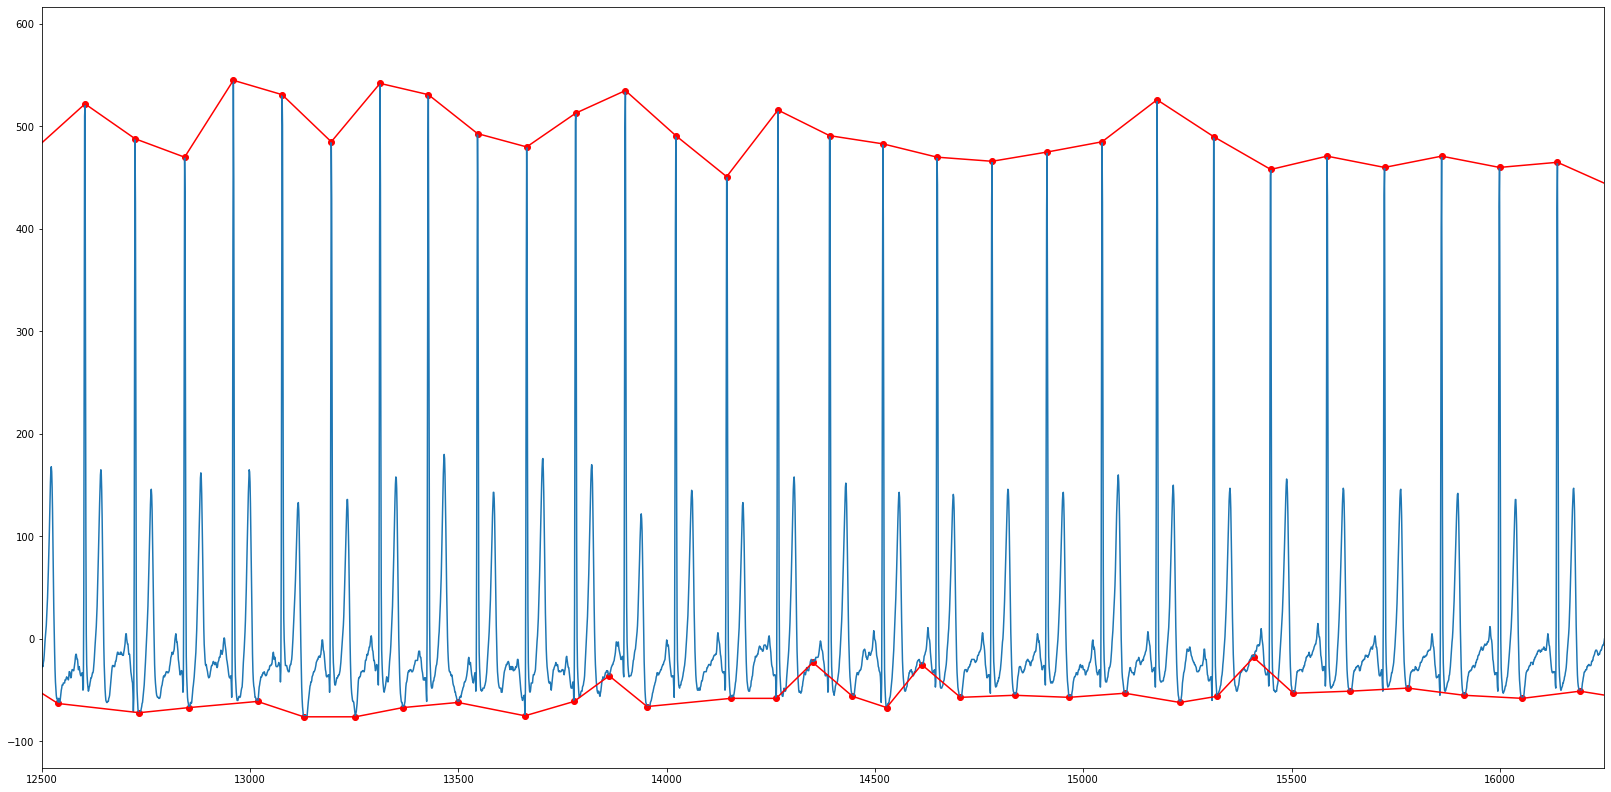

In [654]:
pt_number='0a405f6a12933ff7967d'
csa_day = '20201209'
csa_time_be = '070000'
csa_time_af = '071000'
osa_day = '20201208'
oas_time_be = '150000'
oas_time_af = '151000'
signal_list=os.listdir('/home/jovyan/work/biosignal/GZIP/'+pt_number+'/'+osa_day)
DIR_='/home/jovyan/work/biosignal/GZIP/'+pt_number+'/'+osa_day
ECG_ = read_nk(DIR_+'/'+osa_day+oas_time_be+'_'+osa_day+oas_time_af+'_ECGII.gz','ECGII')
RES_ = read_nk(DIR_+'/'+osa_day+oas_time_be+'_'+osa_day+oas_time_af+'_RESPIMP.gz','RESPIMP')
rr, _ = find_peaks(ECG_, distance=80, height=2*np.mean(ECG_))
#_rr, m_ = find_peaks(-ECG_, distance=80, height=2*np.mean(ECG_))
peak_=_['peak_heights']
m_peak_=-m_['peak_heights']
plt.plot(ECG_)
plt.plot(rr, peak_,color='red')
plt.scatter(rr, peak_,color='red')
plt.plot(m_rr, m_peak_,color='red')
plt.scatter(m_rr, m_peak_,color='red')
plt.xlim(125*100,125*130)
#plt.show()
print(len(rr),len(m_rr))


(62500.0, 75000.0)

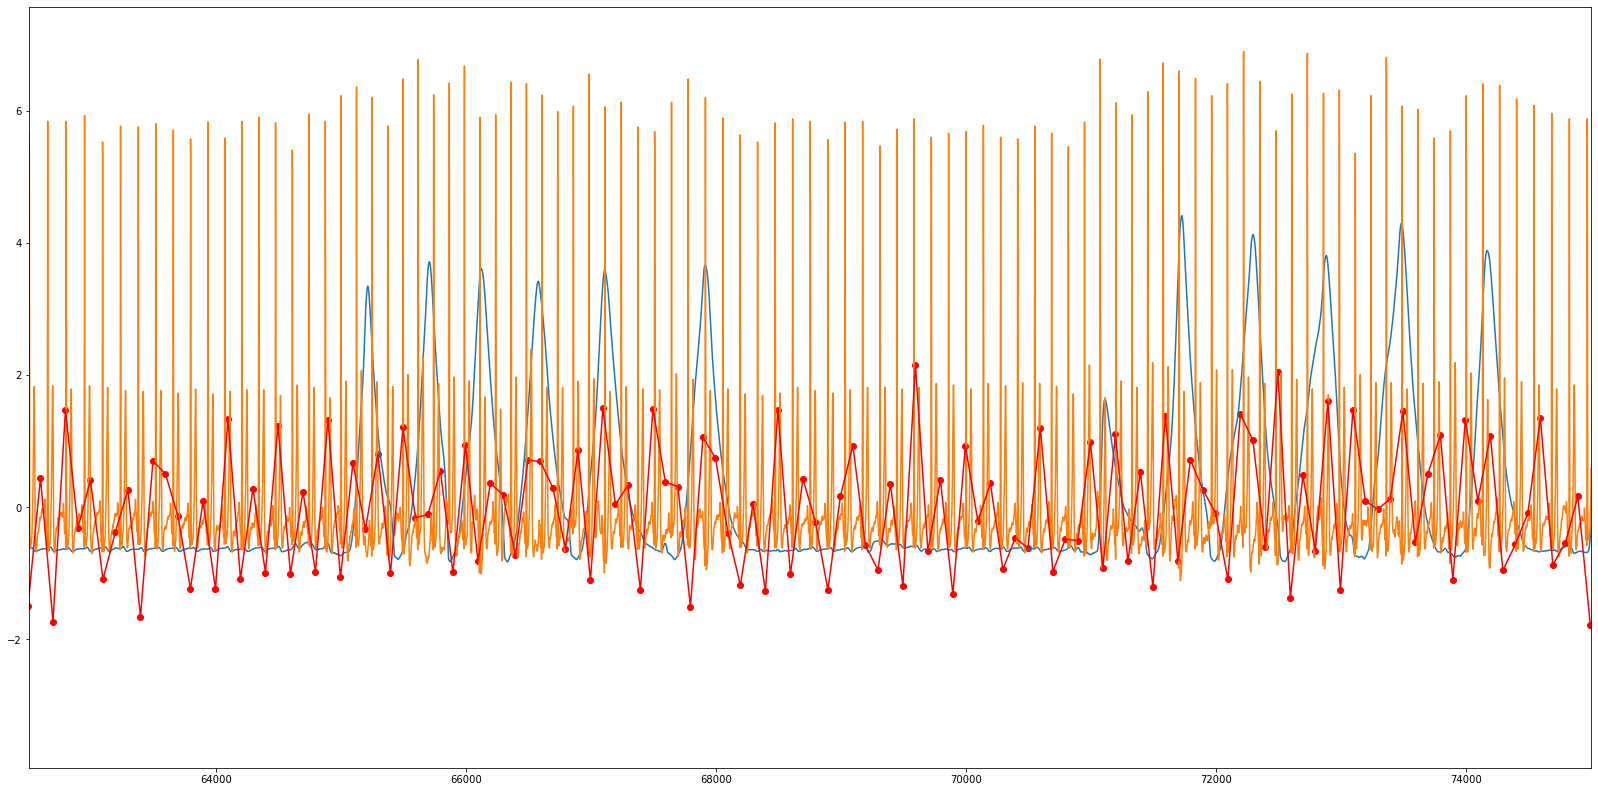

In [650]:
pt_number='0a405f6a12933ff7967d'
csa_day = '20201209'
csa_time_be = '070000'
csa_time_af = '071000'
osa_day = '20201208'
oas_time_be = '150000'
oas_time_af = '151000'
signal_list=os.listdir('/home/jovyan/work/biosignal/GZIP/'+pt_number+'/'+osa_day)
DIR_='/home/jovyan/work/biosignal/GZIP/'+pt_number+'/'+osa_day
ECG_ = read_nk(DIR_+'/'+osa_day+oas_time_be+'_'+osa_day+oas_time_af+'_ECGII.gz','ECGII')
RES_ = read_nk(DIR_+'/'+osa_day+oas_time_be+'_'+osa_day+oas_time_af+'_RESPIMP.gz','RESPIMP')
score_list = []
index_list = []
se = 80## 최대값과 최소값을 뽑을 구간을 정한다
len_ = 75000
for i in range(int(len_/se)):## 최대값과 최소값을 뽑은후 점을 찍을 위치는 중간값을 정한다.
    tmp=ECG_[i*int(se):(i+1)*int(se)]
    score_list.append(max(tmp))
    score_list.append(min(tmp))
    max_index=list(tmp).index(max(tmp)) + (i+1)*se 
    min_index=list(tmp).index(min(tmp)) + (i+1)*se  
    index=int((max_index + min_index) / 2)
    index_list.append(index)
di_list = []## 최대값과 최소값의 차이를 구한다.
for i in range(int(len_/se)):
    di_list.append(score_list[2*i] + score_list[2*(i)+1])
di_array = np.array(di_list)
di_array_ = (di_array - di_array.mean()) / di_array.std()

f1 = interpolate.interp1d(index_list,di_array_,kind='cubic')
x_new = np.linspace(index_list[0],index_list[-1],num=750,endpoint=True)
f1_x=f1(x_new)
f1_x_ = (f1(x_new) - f1(x_new).mean()) / f1(x_new).std()
ECG_n = (ECG_ - ECG_.mean()) / ECG_.std()
RES_n = (RES_ - RES_.mean()) / RES_.std()
peak_n = (peak_ - peak_.mean()) / peak_.std()
plt.plot(RES_n)
plt.plot(ECG_n)
plt.plot(x_new, f1_x_, color='red')
plt.scatter(x_new, f1_x_, color='red')
#plt.ylim(min(RES_n),max(RES_n))
plt.xlim(125*500,125*600)


(12500.0, 25000.0)

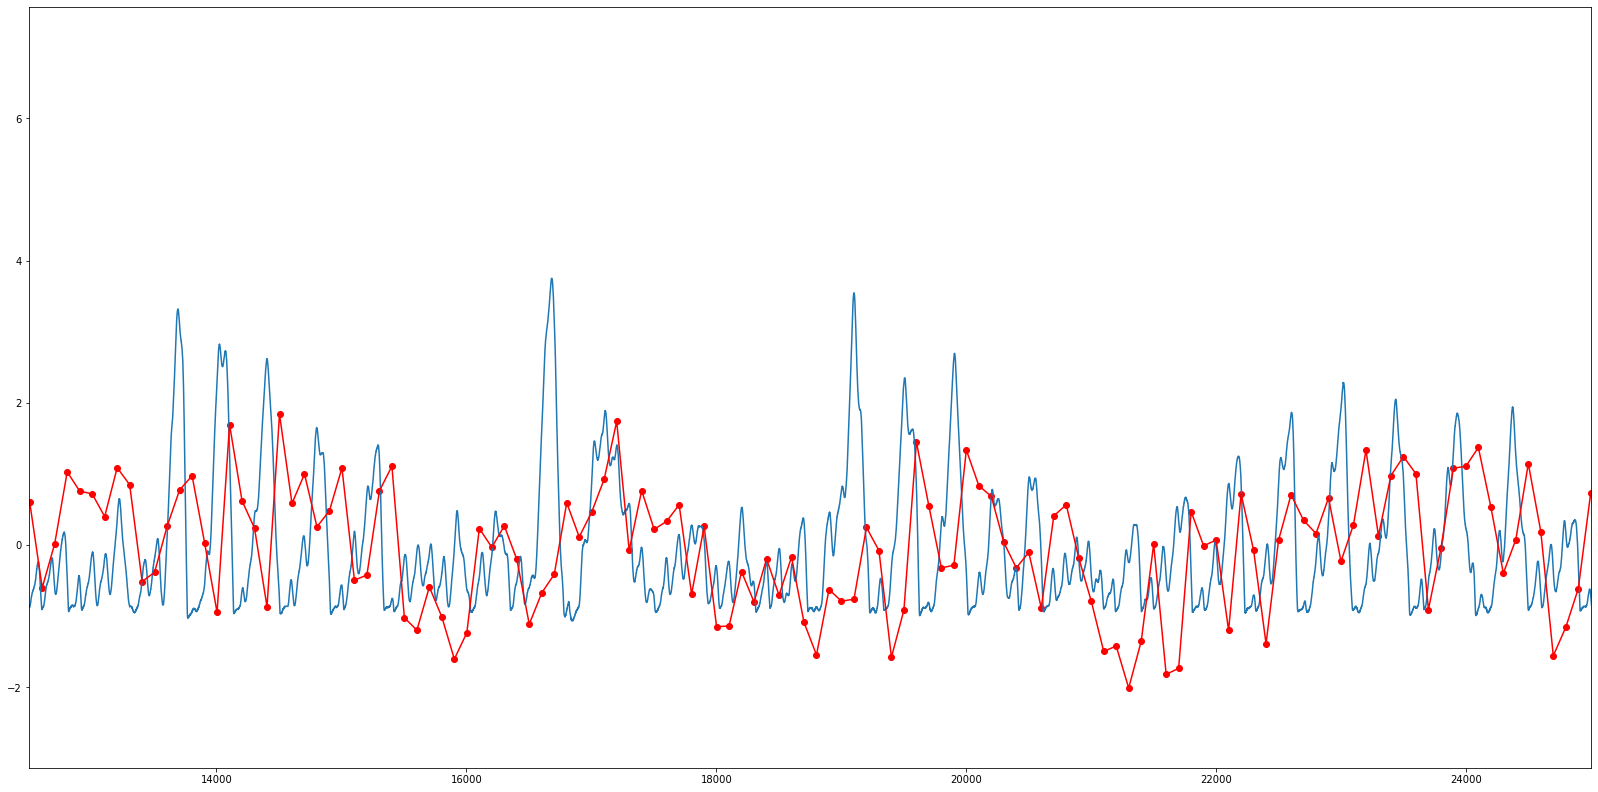

In [717]:
csa_pt_number = '0d5c19c9338f9c1aa5b9'
csa_day = '20200903'
csa_time_be = '073000'
csa_time_af = '074000'

osa_day = '20201208'
oas_time_be = '150000'
oas_time_af = '151000'
signal_list=os.listdir('/home/jovyan/work/biosignal/GZIP/'+csa_pt_number+'/'+csa_day)
DIR_='/home/jovyan/work/biosignal/GZIP/'+csa_pt_number+'/'+csa_day
ECG_ = read_nk(DIR_+'/'+csa_day+csa_time_be+'_'+csa_day+csa_time_af+'_ECGII.gz','ECGII')
RES_ = read_nk(DIR_+'/'+csa_day+csa_time_be+'_'+csa_day+csa_time_af+'_RESPIMP.gz','RESPIMP')

rr, _ = find_peaks(ECG_, distance=80, height=2*np.mean(ECG_))## peak를 구하고
peak_=_['peak_heights']
m_rr = []
index_list = []
for i in range(len(rr)):
    try:
        m_rr.append(min(ECG_[rr[i]:rr[i+1]]))## peak와 다음 peak 사이중에 최소값을 구한다
        index_list.append(int(rr[i]+rr[i+1])/2)
    except:
        m_rr.append(min(ECG_[rr[i]:]))
        index_list.append(int(rr[i]+len(ECG_))/2)
di_list = []
for i in range(len(m_rr)):
    di_list.append(peak_[i] - m_rr[i])  ## peak값과 최소값의 차이를 점으로 이용
di_array = np.array(di_list)
di_array_ = (di_array - di_array.mean()) / di_array.std()

f1 = interpolate.interp1d(index_list[:-1],di_array_[:-1],kind='cubic')
x_new = np.linspace(index_list[0],index_list[-2],num=750,endpoint=True)
f1_x=f1(x_new)
f1_x_ = (f1(x_new) - f1(x_new).mean()) / f1(x_new).std()
ECG_n = (ECG_ - ECG_.mean()) / ECG_.std()
RES_n = (RES_ - RES_.mean()) / RES_.std()
peak_n = (peak_ - peak_.mean()) / peak_.std()
plt.plot(RES_n)
#plt.plot(ECG_n)
plt.plot(x_new, f1_x_, color='red')
plt.scatter(x_new, f1_x_, color='red')
plt.xlim(125*100,125*200)



In [619]:
len_/se

937.5

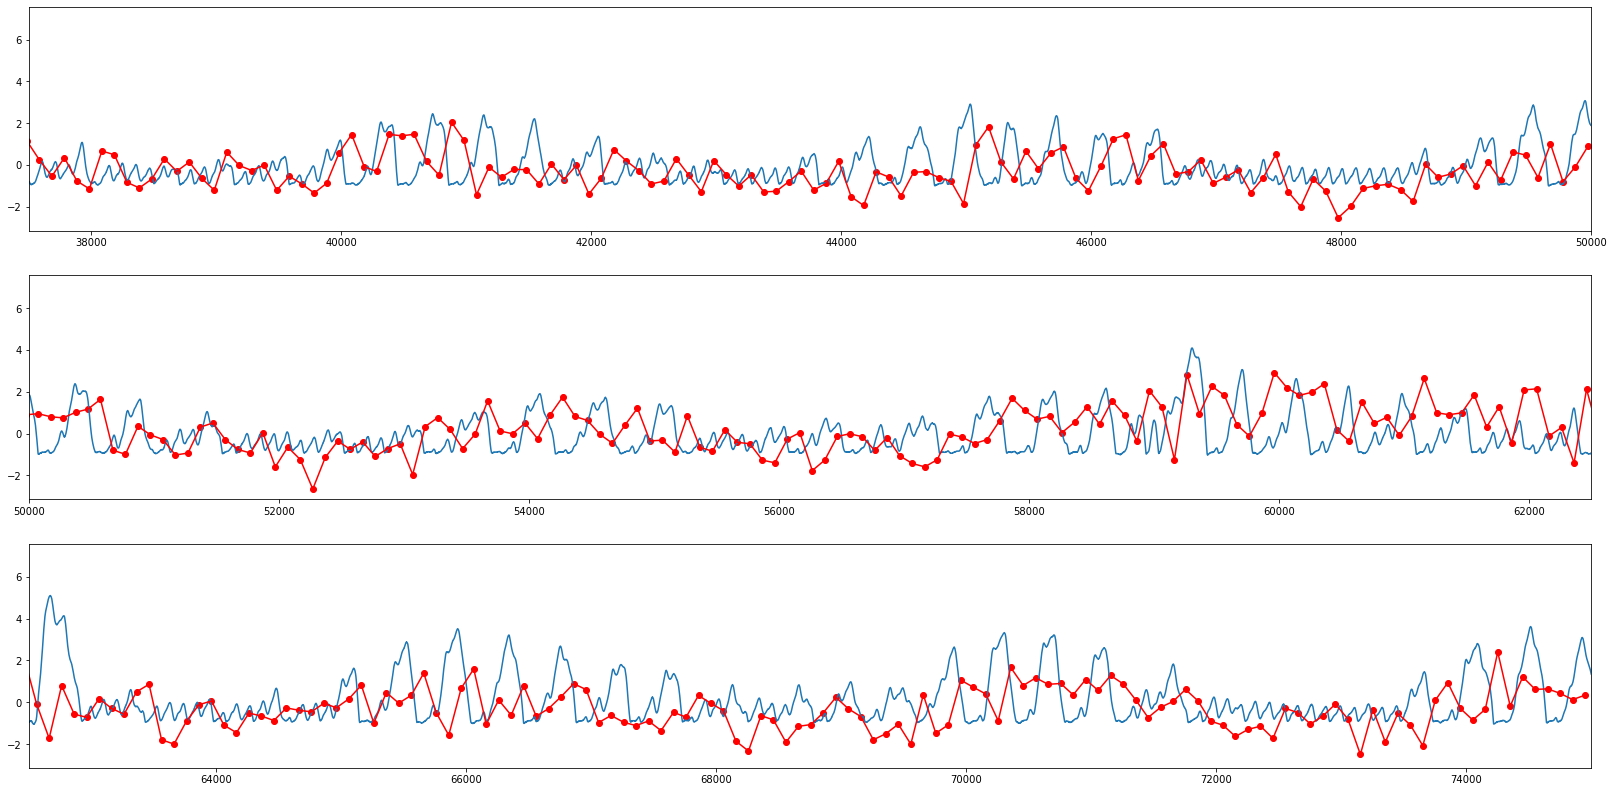

In [719]:
csa_pt_number = '0d5c19c9338f9c1aa5b9'
csa_day = '20200903'
csa_time_be = '073000'
csa_time_af = '074000'

osa_day = '20201208'
oas_time_be = '150000'
oas_time_af = '151000'
signal_list=os.listdir('/home/jovyan/work/biosignal/GZIP/'+csa_pt_number+'/'+csa_day)
DIR_='/home/jovyan/work/biosignal/GZIP/'+csa_pt_number+'/'+csa_day
ECG_ = read_nk(DIR_+'/'+csa_day+csa_time_be+'_'+csa_day+csa_time_af+'_ECGII.gz','ECGII')
RES_ = read_nk(DIR_+'/'+csa_day+csa_time_be+'_'+csa_day+csa_time_af+'_RESPIMP.gz','RESPIMP')

rr, _ = find_peaks(ECG_, distance=80, height=2*np.mean(ECG_))## peak를 구하고
peak_=_['peak_heights']
m_rr = []
index_list = []
for i in range(len(rr)):
    try:
        m_rr.append(min(ECG_[rr[i]:rr[i+1]]))## peak와 다음 peak 사이중에 최소값을 구한다
        index_list.append(int(rr[i]+rr[i+1])/2)
    except:
        m_rr.append(min(ECG_[rr[i]:]))
        index_list.append(int(rr[i]+len(ECG_))/2)
di_list = []
for i in range(len(m_rr)):
    di_list.append(peak_[i] - m_rr[i])  ## peak값과 최소값의 차이를 점으로 이용
di_array = np.array(di_list)
di_array_ = (di_array - di_array.mean()) / di_array.std()

f1 = interpolate.interp1d(index_list[:-1],di_array_[:-1],kind='cubic')
x_new = np.linspace(index_list[0],index_list[-2],num=750,endpoint=True)
f1_x=f1(x_new)
f1_x_ = (f1(x_new) - f1(x_new).mean()) / f1(x_new).std()
ECG_n = (ECG_ - ECG_.mean()) / ECG_.std()
RES_n = (RES_ - RES_.mean()) / RES_.std()
peak_n = (peak_ - peak_.mean()) / peak_.std()
#plt.plot(RES_n)
#plt.plot(ECG_n)
#plt.plot(x_new, f1_x_, color='red')
#plt.scatter(x_new, f1_x_, color='red')
#plt.ylim(min(RES_n),max(RES_n))
#plt.xlim(125*0,125*100)
fig = plt.figure()## 그래프 객체 생성

ax1 = fig.add_subplot(3,1,1)    
ax1.plot(RES_n)
ax1.plot(x_new, f1_x_, color='red')
ax1.scatter(x_new, f1_x_, color='red')
ax1.set_xlim(125*300,125*400)

ax2 = fig.add_subplot(3,1,2)     
ax2.plot(RES_n)
ax2.plot(x_new, f1_x_, color='red')
ax2.scatter(x_new, f1_x_, color='red')
ax2.set_xlim(125*400,125*500)

ax3 = fig.add_subplot(3,1,3)     
ax3.plot(RES_n)
ax3.plot(x_new, f1_x_, color='red')
ax3.scatter(x_new, f1_x_, color='red')
ax3.set_xlim(125*500,125*600)
plt.show()

In [ ]:
all_rr = []
for i in range(len(rr)):
    ind = 0
    di = 1
    while di > 0 :
        di = rr[i] - m_rr[ind]  
        ind = ind + 1
    
    all_rr.append(di)
    di = 1

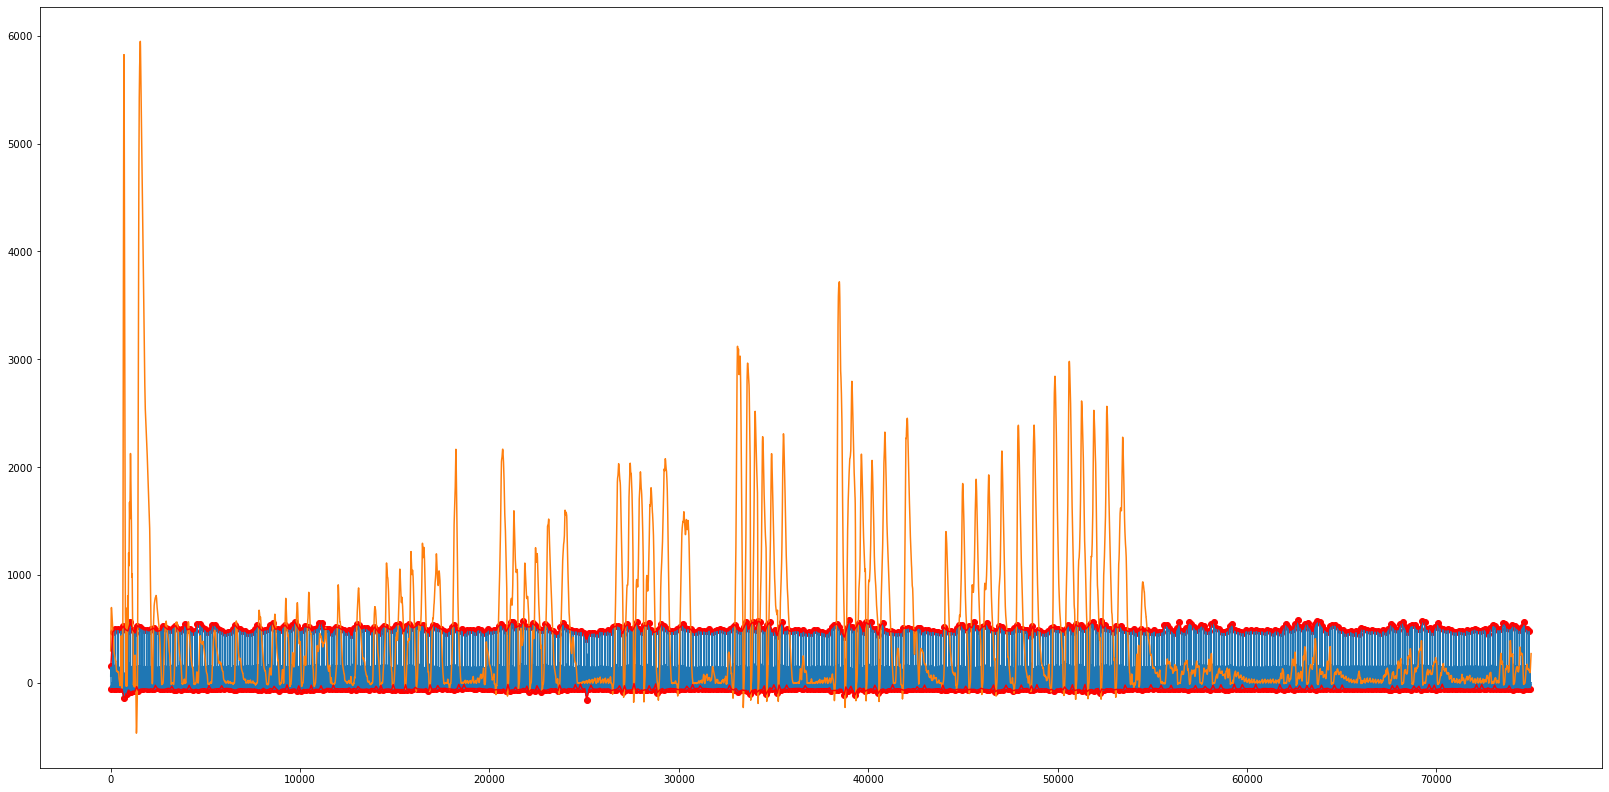

In [526]:
pt_number='0a405f6a12933ff7967d'
csa_day = '20201209'
csa_time_be = '070000'
csa_time_af = '071000'
osa_day = '20201208'
oas_time_be = '151000'
oas_time_af = '152000'
signal_list=os.listdir('/home/jovyan/work/biosignal/GZIP/'+pt_number+'/'+osa_day)
DIR_='/home/jovyan/work/biosignal/GZIP/'+pt_number+'/'+osa_day
ECG_ = read_nk(DIR_+'/'+osa_day+oas_time_be+'_'+osa_day+oas_time_af+'_ECGII.gz','ECGII')
RES_ = read_nk(DIR_+'/'+osa_day+oas_time_be+'_'+osa_day+oas_time_af+'_RESPIMP.gz','RESPIMP')
rr, _ = find_peaks(ECG_, distance=80, height= np.mean(ECG_))
m_rr, m_ = find_peaks(-ECG_, distance=80, height= np.mean(ECG_))
peak_=_['peak_heights']
m_peak_=-m_['peak_heights']
import numpy as np
import matplotlib.pyplot as plt

f1 = interpolate.interp1d(rr,peak_,kind='cubic')## ecg 에서 peak detecetion 
x_new = np.linspace(rr[0],rr[-1],num=75000,endpoint=True)
f1_x=f1(x_new)
f1_x_ = (f1(x_new) - f1(x_new).mean()) / f1(x_new).std()
ECG_n = (ECG_ - ECG_.mean()) / ECG_.std()
RES_n = (RES_ - RES_.mean()) / RES_.std()
peak_n = (peak_ - peak_.mean()) / peak_.std()

len(rr)
f1_x=f1(x_new)
f1_x_ = (f1(x_new) - f1(x_new).mean()) / f1(x_new).std()

ECG_n = (ECG_ - ECG_.mean()) / ECG_.std()

RES_n = (RES_ - RES_.mean()) / RES_.std()

peak_n = (peak_ - peak_.mean()) / peak_.std()
inp_mean=np.mean(f1_x_)
inp_std=np.std(f1_x_)

plt.plot(ECG_)
plt.plot(RES_)
plt.plot(rr, _['peak_heights'], color='red')
plt.scatter(rr, _['peak_heights'],color='red')
#plt.plot(x_new, f1_x_,color='red')
#plt.scatter(x_new, f1_x_,color='red')
plt.plot(m_rr, -m_['peak_heights'], color='red')
plt.scatter(m_rr, -m_['peak_heights'],color='red')
#plt.xlim(125*10,125*20)

In [631]:
#m_peak_

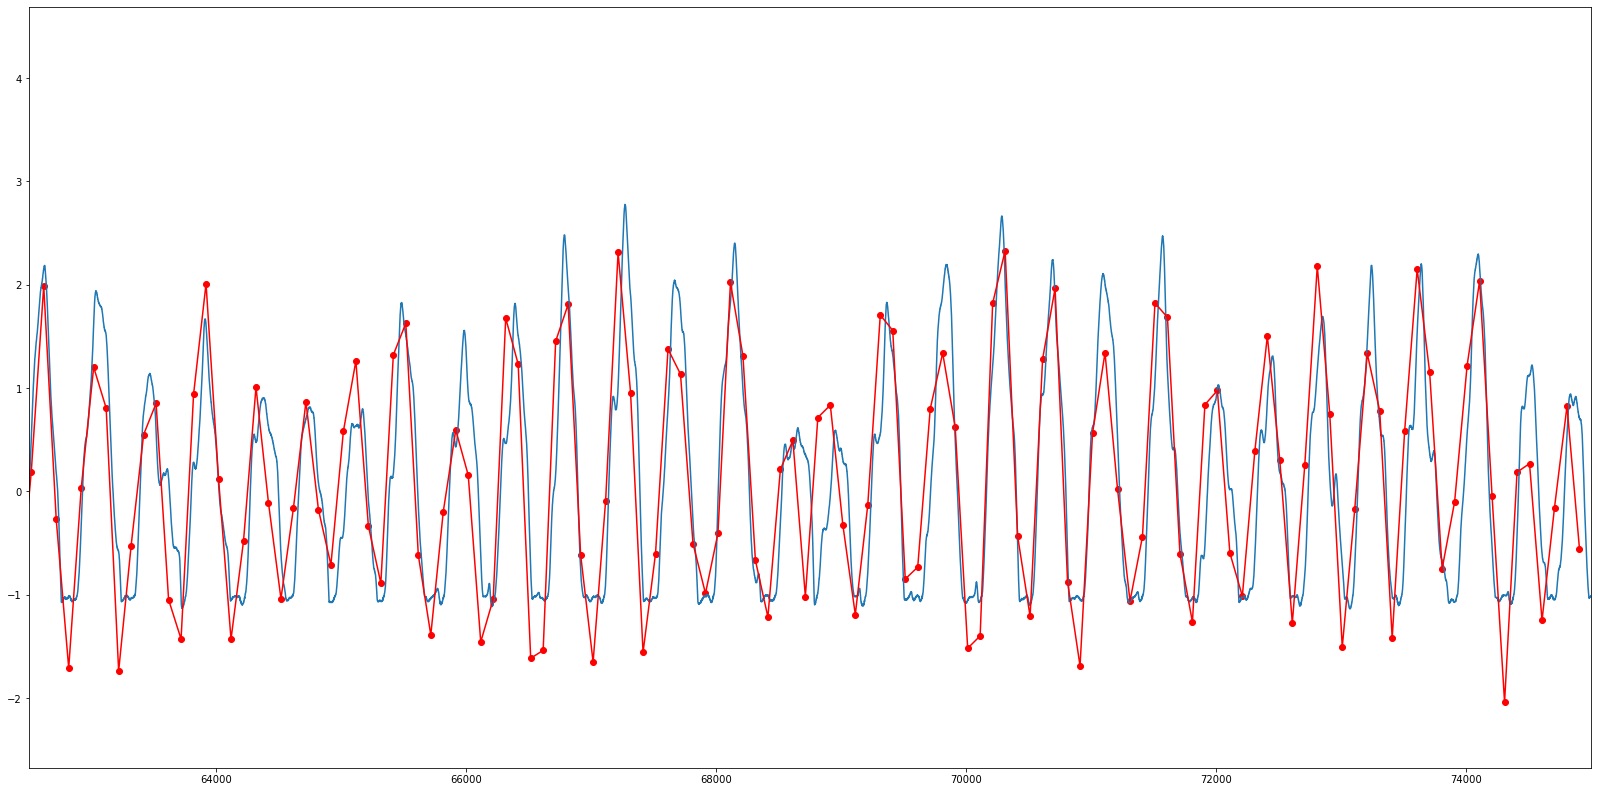

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

f1 = interpolate.interp1d(rr,peak_,kind='linear')## ecg 에서 peak detecetion 
x_new = np.linspace(rr[0],rr[-1],num=75000,endpoint=True)
f1_x=f1(x_new)
f1_x_ = (f1(x_new) - f1(x_new).mean()) / f1(x_new).std()
ECG_n = (ECG_ - ECG_.mean()) / ECG_.std()
RES_n = (RES_ - RES_.mean()) / RES_.std()
peak_n = (peak_ - peak_.mean()) / peak_.std()

#len(rr)
#plt.plot(ECG_)
#plt.plot(RES_)
#plt.plot(rr, peak_,color='red')
#plt.scatter(rr, peak_,color='red')
#plt.plot(m_rr, m_peak_,color='red')
#plt.scatter(m_rr, m_peak_,color='red')
#plt.xlim(125,125*20)
#plt.show()

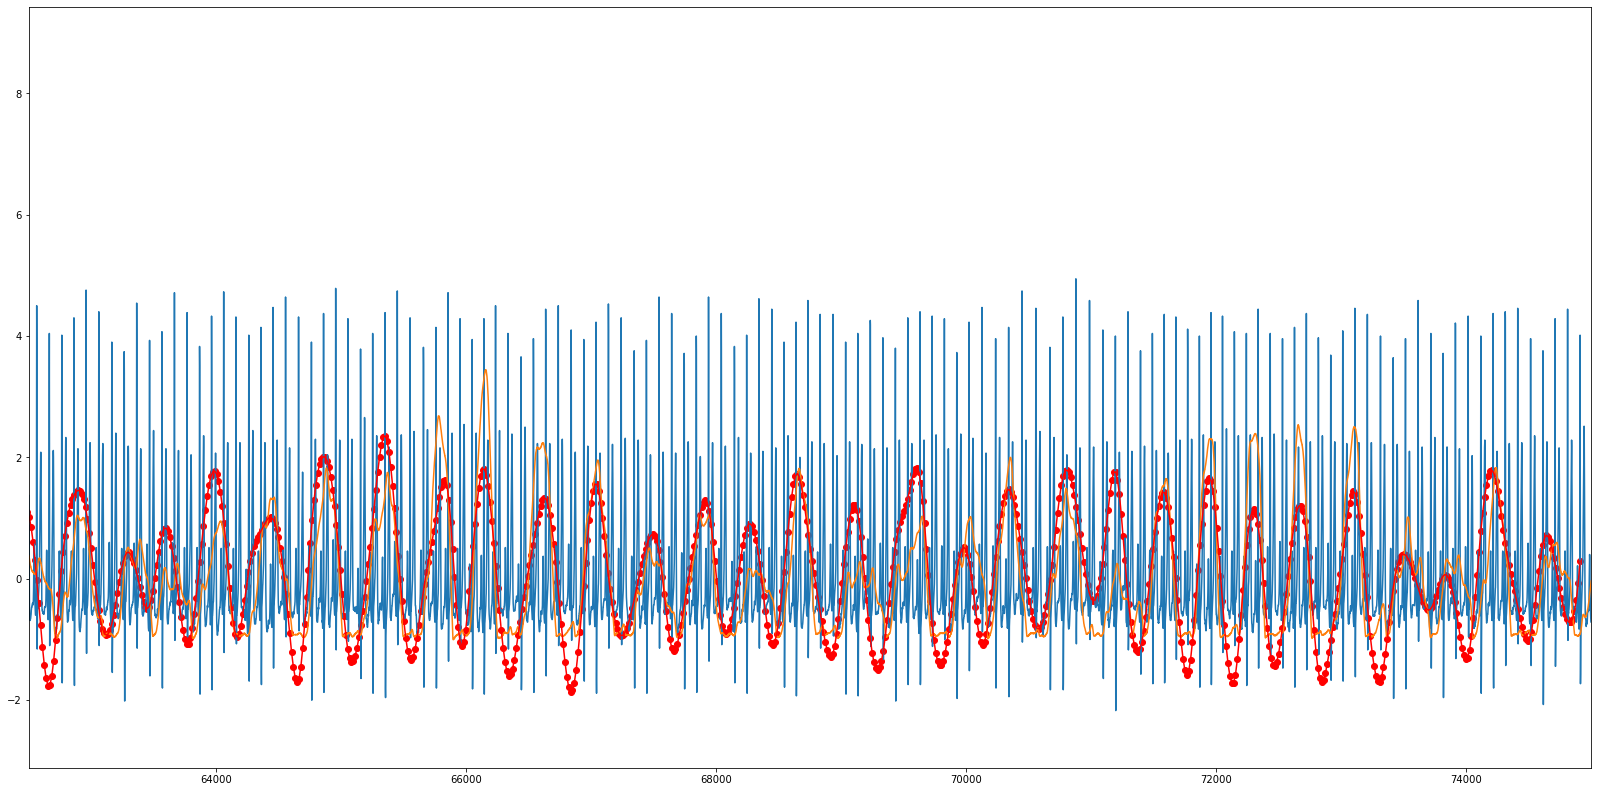

In [217]:
all_rr = []
for i in range(len(m_rr)):
    all_rr.append(rr[i])
    #all_rr.append(m_rr[i])
all_rr=np.array(all_rr)
all_peak = []
for i in range(len(m_rr)):
    all_peak.append(peak_[i]+m_peak_[i])
    #all_peak.append(m_peak_[i])
all_peak=np.array(all_peak)
plt.plot(ECG_n)
plt.plot(RES_n)
plt.plot(x_new, f1_x_,color='red')
plt.scatter(x_new, f1_x_,color='red')
plt.xlim(125*500,125*600)
plt.show()

In [181]:
##all_rr

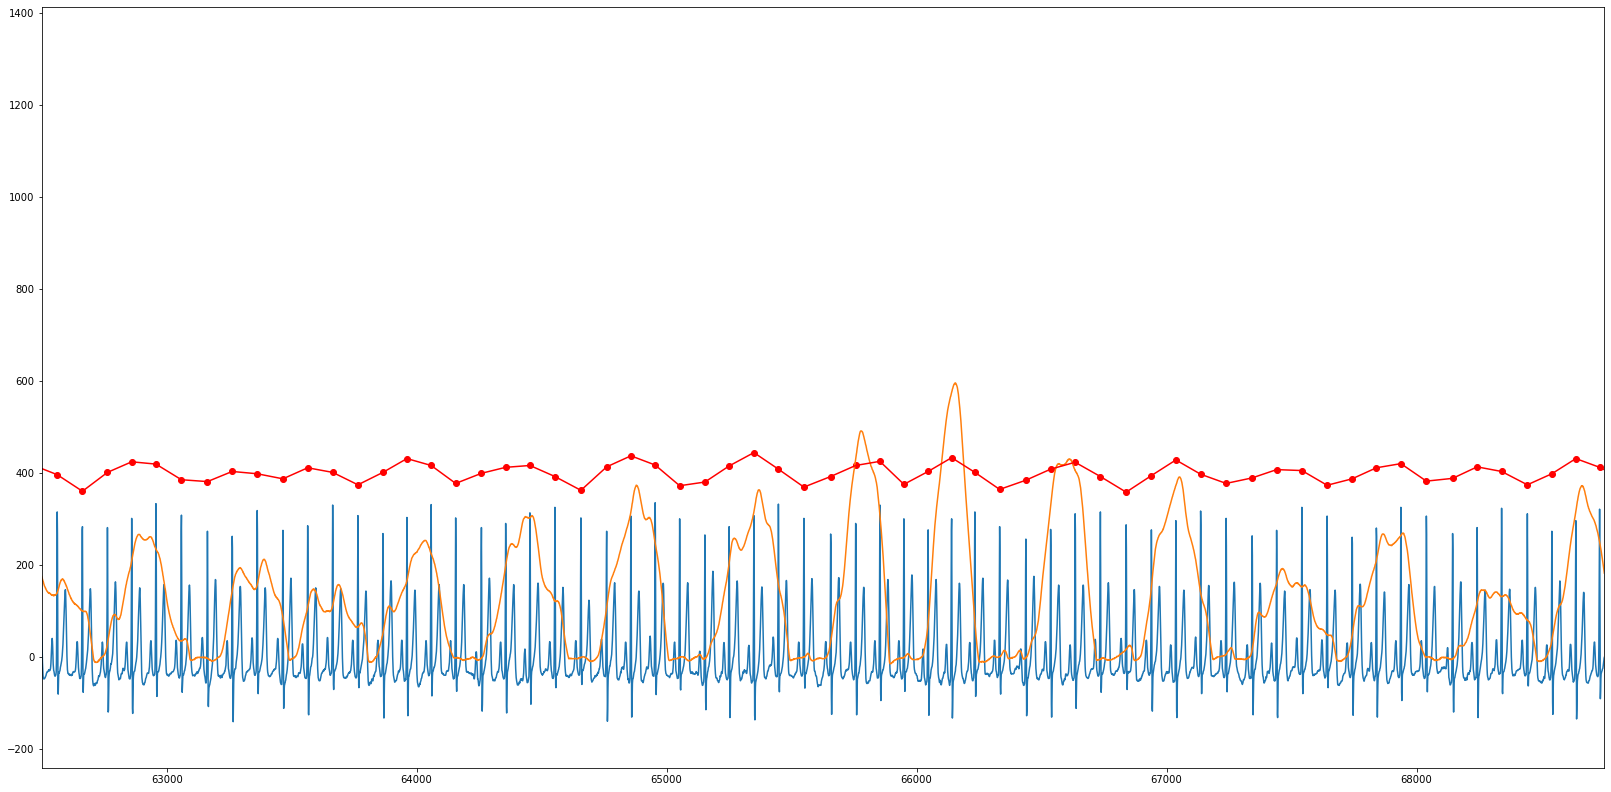

In [197]:
all_rr = []
for i in range(len(m_rr)):
    all_rr.append(rr[i])
    
all_rr=np.array(all_rr)
all_peak = []
for i in range(len(m_rr)):
    all_peak.append(peak_[i]-m_peak_[i])
    
all_peak=np.array(all_peak)
plt.plot(ECG_)
plt.plot(RES_)
plt.plot(all_rr, all_peak,color='red')
plt.scatter(all_rr, all_peak,color='red')
plt.xlim(125*500,125*550)
plt.show()

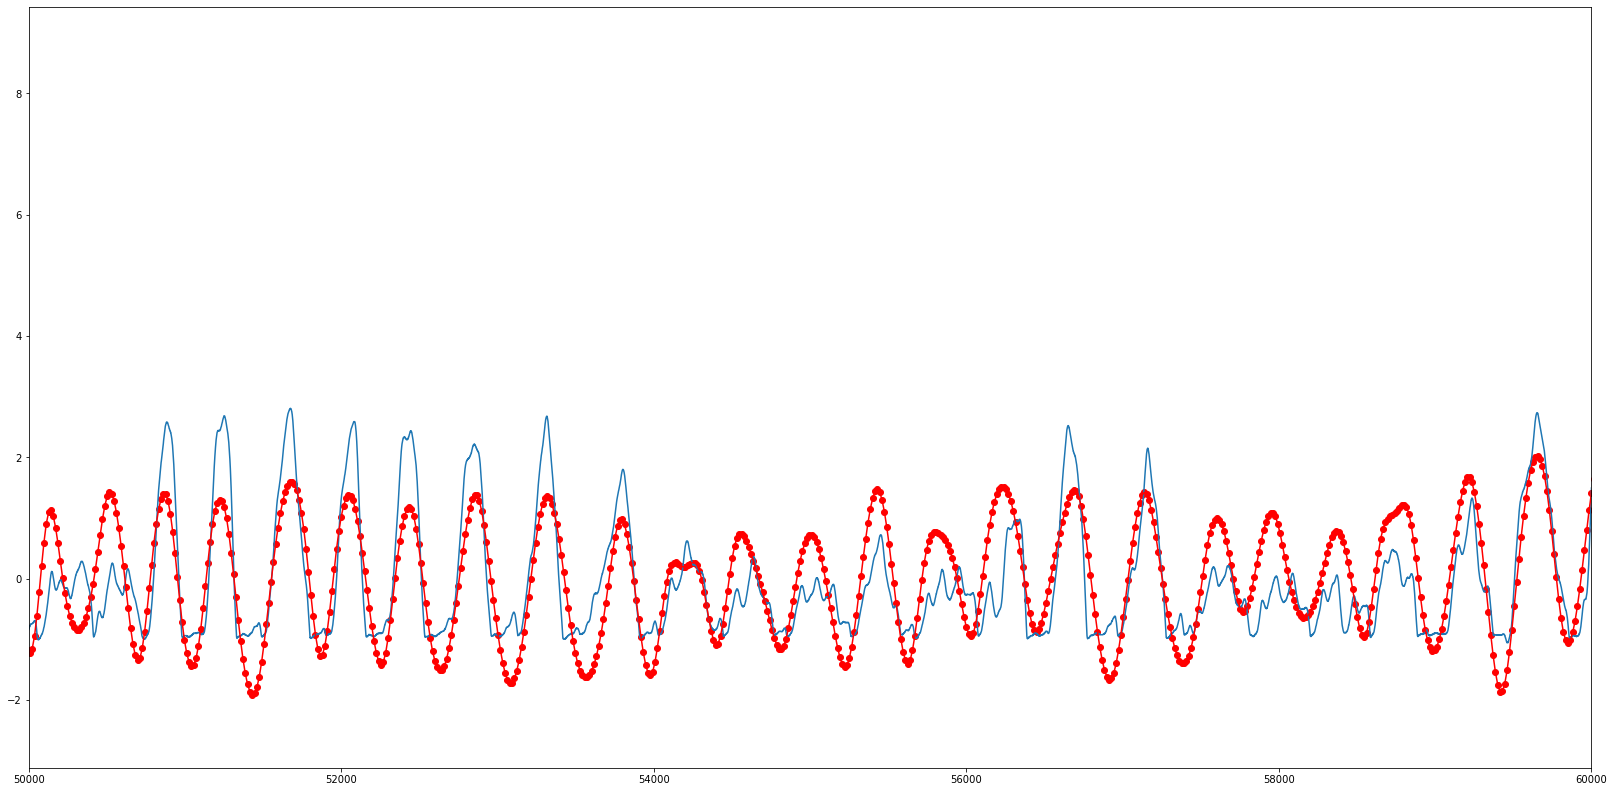

In [196]:
f1 = interpolate.interp1d(all_rr,all_peak,kind='cubic')## 찾은 peak를 이용해 보간법 진행 종류는 liear,zero,cubic,previous,quadratic
x_new = np.linspace(all_rr[0],all_rr[-1],num=5000,endpoint=True)## 시작과 끝점을 정하고 num 인자를 통해 점의 갯수를 정한다.

f1_x=f1(x_new)
f1_x_ = (f1(x_new) - f1(x_new).mean()) / f1(x_new).std()

ECG_n = (ECG_ - ECG_.mean()) / ECG_.std()

RES_n = (RES_ - RES_.mean()) / RES_.std()

peak_n = (peak_ - peak_.mean()) / peak_.std()
inp_mean=np.mean(f1_x_)
inp_std=np.std(f1_x_)

len(rr)
#plt.plot(ECG_)
#plt.plot(RES_n)
plt.plot(RES_n)
plt.plot(x_new, f1_x_,color='red')
plt.scatter(x_new, f1_x_,color='red')
plt.xlim(50000,60000)
plt.show()

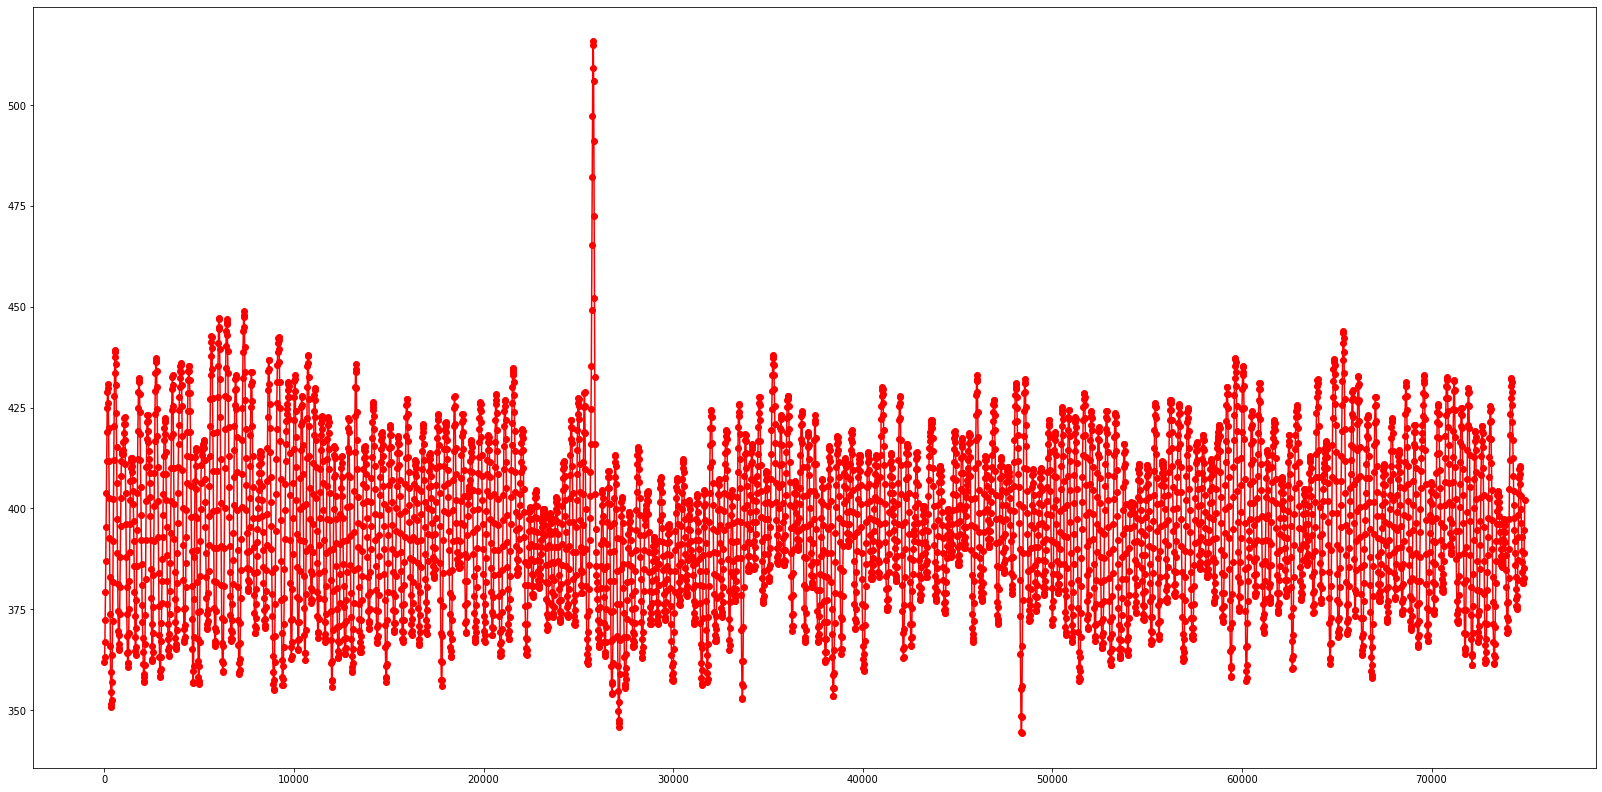

In [190]:
#plt.plot(RES_)
plt.plot(x_new, f1_x,color='red')
plt.scatter(x_new, f1_x,color='red')
#plt.xlim(125,125*150)
plt.show()

0.1


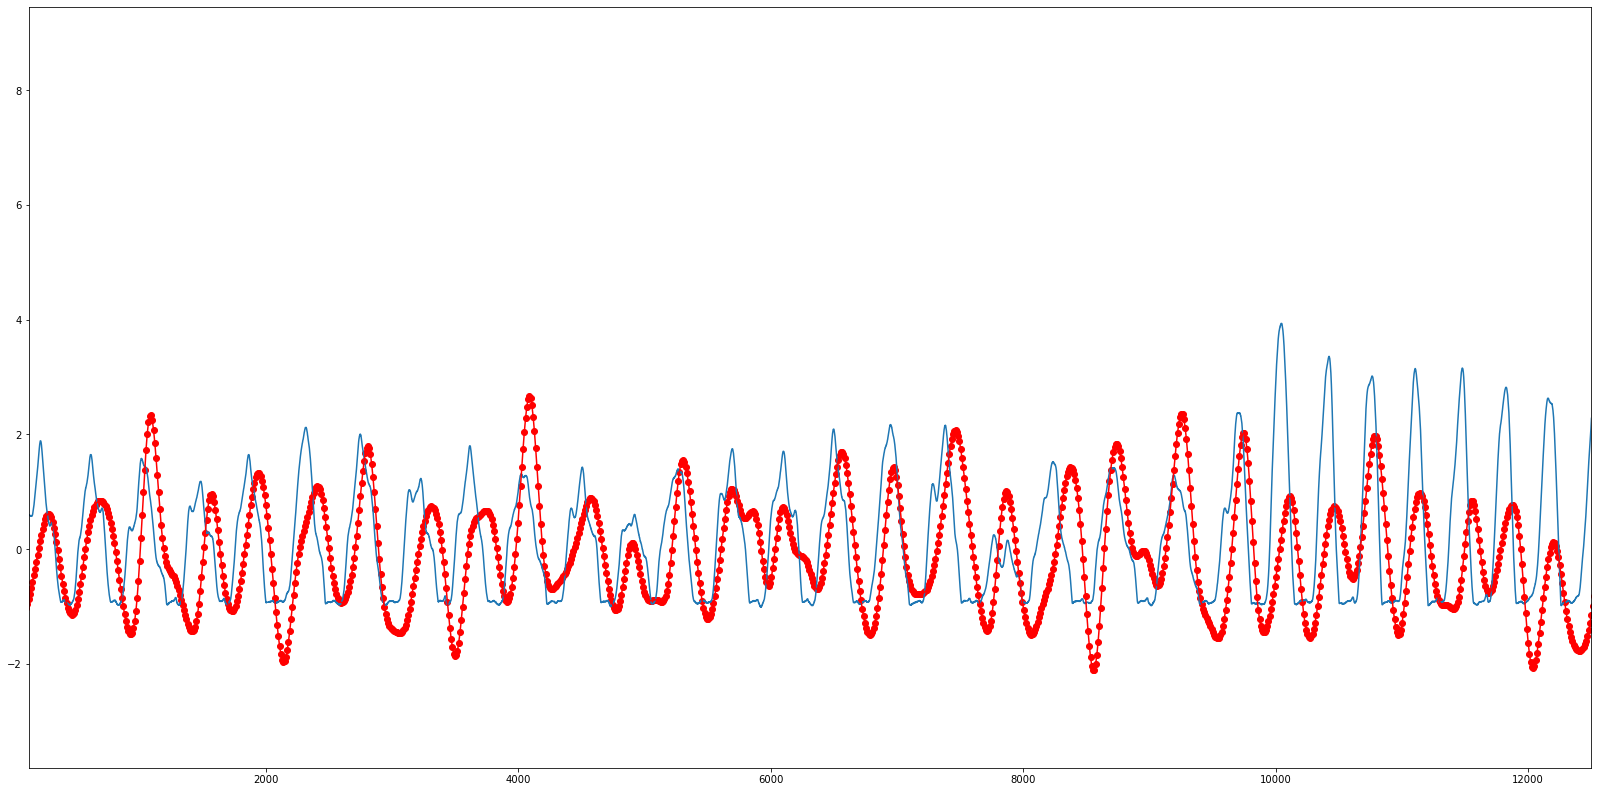

In [172]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import detrend, find_peaks
signal_list=os.listdir('/home/jovyan/work/biosignal/GZIP/0a2ce80208e2cf726f1b/20210406')
DIR_='/home/jovyan/work/biosignal/GZIP/0a2ce80208e2cf726f1b/20210406'
ecg_list = []
res_list = []
for si in range(len(signal_list)):    
    if signal_list[si].split('_')[-1] == 'ECGII.gz':
        ecg_list.append(signal_list[si])
for re in range(len(signal_list)):    
    if signal_list[re].split('_')[-1] == 'RESPIMP.gz':
        res_list.append(signal_list[re])
ECG_ = read_nk(DIR_+'/'+ecg_list[2],'ECGII')
RES_ = read_nk(DIR_+'/'+res_list[2],'RESPIMP')

weight = 0.1
rr = [1]
while 600 > len(rr) or len(rr) > 1100 :
    print(weight)
    #print(len(rr))       
    rr, _ = find_peaks(ECG_, distance=80, height=weight * np.mean(ECG_) )## distance 80 및 
    m_rr, m_ = find_peaks(-ECG_, distance=80, height=2*np.mean(ECG_))
    ## 적당한 Peak의 갯수를 맞추기위해 whlie 문 진행
    
    ## 10분당 75000 기준
    if 600 < len(rr) <1100:       
        break       
    else:         
        weight = weight + 0.1  

#rr=np.insert(rr,0,0)
peak_=_['peak_heights']
m_peak_=-m_['peak_heights']
import numpy as np
import matplotlib.pyplot as plt

f1 = interpolate.interp1d(rr,peak_,kind='cubic')## 찾은 peak를 이용해 보간법 진행 종류는 liear,zero,cubic,previous,quadratic
x_new = np.linspace(rr[0],rr[-1],num=7500,endpoint=True)## 시작과 끝점을 정하고 num 인자를 통해 점의 갯수를 정한다.

f1_x=f1(x_new)
f1_x_ = (f1(x_new) - f1(x_new).mean()) / f1(x_new).std()

ECG_n = (ECG_ - ECG_.mean()) / ECG_.std()

RES_n = (RES_ - RES_.mean()) / RES_.std()

peak_n = (peak_ - peak_.mean()) / peak_.std()
inp_mean=np.mean(f1_x_)
inp_std=np.std(f1_x_)

len(rr)
#plt.plot(ECG_n)
plt.plot(RES_n)
plt.plot(x_new, f1_x_,color='red')
plt.scatter(x_new, f1_x_,color='red')
#plt.plot(rr, peak_,color='red')
#plt.scatter(rr, peak_,color='red')
#plt.plot(m_rr, m_peak_,color='red')
#plt.scatter(m_rr, m_peak_,color='red')
plt.xlim(125,125*100)
plt.show()


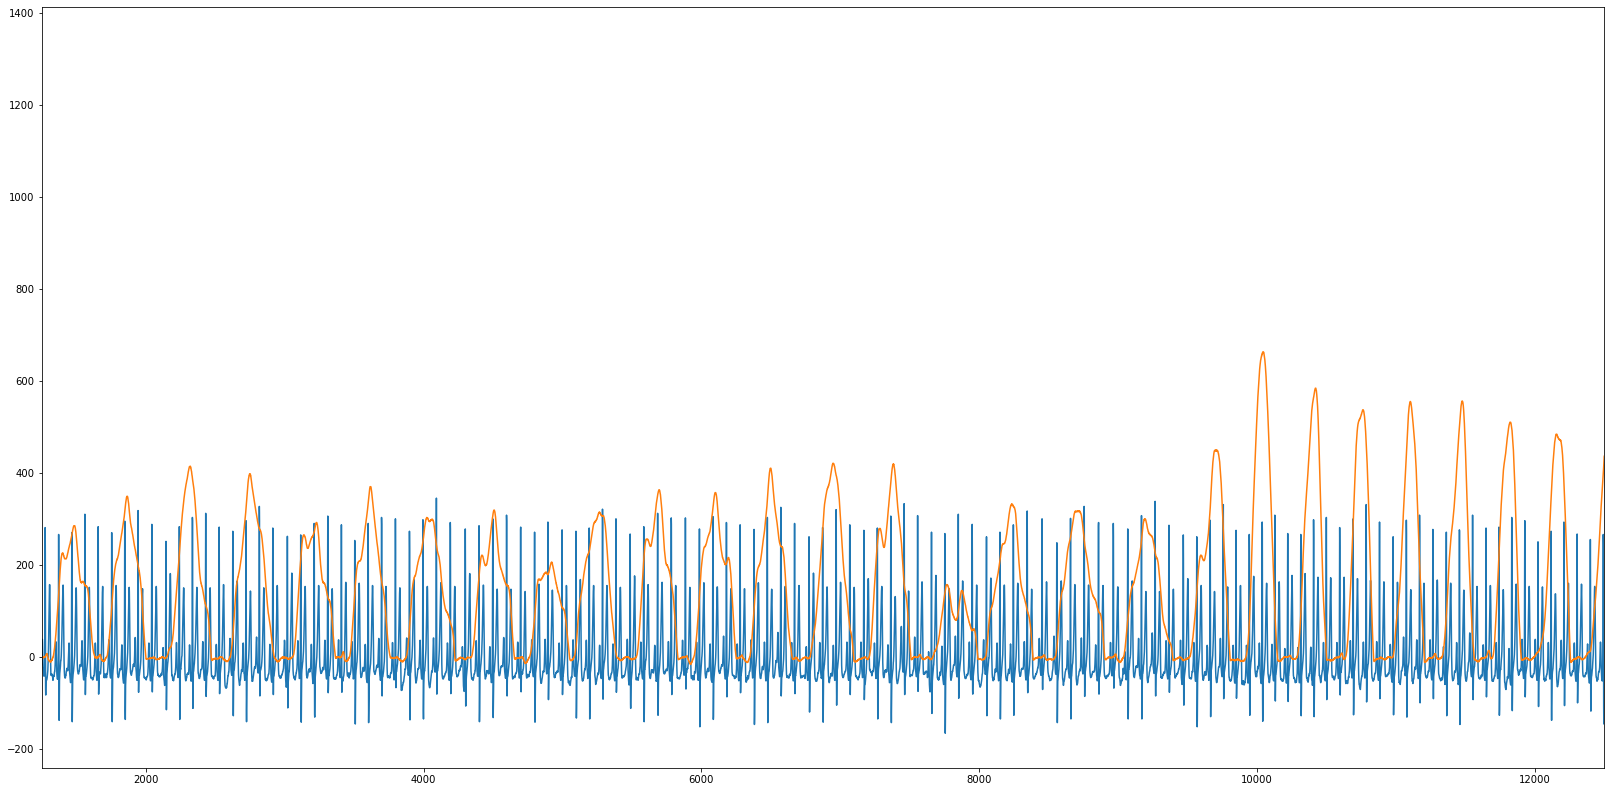

In [146]:
plt.plot(ECG_)
plt.plot(RES_)
#plt.plot(rr, peak_,color='red')
#plt.scatter(rr, peak_,color='red')
plt.xlim(1250,125*100)
plt.show()